# Main thing

We propose XGCN, an extension of RGCN to accomodate continuous features (with gpu-friendly operation)

E: (N,N,R)

A: (N,N)

X: (N,H)

stripped down formulation without MLPs (Don't know how to combine einsum notation with activation functions)

$H_{ij}=E_{ikl}A_{ik}X_{kn}\Theta_{lnj}$

code:
```python
class XGCNConv(nn.Module):
    def __init__(self, mlp_dims_edge, mlp_dims_node):
        super().__init__()
        self.mlp_dims_edge=mlp_dims_edge
        self.mlp_dims_node=mlp_dims_node
        self.mlp_edge = MLP(mlp_dims_edge[0], mlp_dims_edge[1:-1], mlp_dims_edge[-1])
        self.mlp_node = MLP(mlp_dims_node[0], mlp_dims_node[1:-1], mlp_dims_node[-1])
    def forward(self, x):
        E, X, A, alt = x
        tmp0=(self.mlp_edge(E)*A).permute(-1,0,1)
        tmp1=tmp0@X
        X = self.mlp_node(tmp1).permute(1,-1,0).sum(-1)
        return E, X, A, alt
```

In [1]:
from pprint import pprint
from convertmol import parse_sdf_file, bond_type_dict, single_bond_stereo_dict, double_bond_stereo_dict
from torch_geometric.data import Data
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
import sascorer
torch.set_default_device('cpu:0')#'cuda'

In [2]:
from mlp import MLP

In [3]:
ATOMS = {
    'C':0,#6,
    'N':1,#7,
    'O':2,#8,
    'F':3,#9,
}

In [4]:
N_ATOMS=len(ATOMS)
N_VALENCY=16 #ℤ∈[0,15]
POS_DIM=3
N_BOND_TYPES=len(bond_type_dict)
N_BOND_STEREO_TYPES=max(len(single_bond_stereo_dict),len(double_bond_stereo_dict))

In [5]:
def convert_valency(s):
    if s == 'no marking':
        return 15
    if s == 'zero valence':
        return 0
    return int(s)

In [6]:
def apply_mapping(tensor, mapping):
    # Convert the mapping dict to a tensor for efficient indexing
    keys = torch.tensor(list(mapping.keys()))
    values = torch.tensor(list(mapping.values()))

    # Create a copy of the input tensor to avoid modifying it directly
    result = tensor.clone()

    # Create a mask to identify the indices that need to be replaced
    for key, value in mapping.items():
        # Apply the mapping
        result[tensor == key] = value

    return result

In [7]:
def parse_mol_dict(mol_dict:dict[str,str|dict[str,str|float]]):
    'mol_dict is a part of the output of parse_sdf_file'
    atoms=dict()
    bonds=list()
    for k,v in mol_dict.items():
        if k.startswith("?atom"):
            atom_id = int(k[len("?atom"):])
            atoms[atom_id]=v
        if (k.startswith("(") and k.endswith(")")):
            assert (v==True), "don't know what non-True value means, here..."
            things = k[1:-1].split(" ")
            assert things[-1].startswith("?atom"), "invalid format"
            assert things[-2].startswith("?atom"), "invalid format"
            bond_type = list(bond_type_dict.values()).index(things[1])
            if things[1]=="Single":
                bond_stereo = list(single_bond_stereo_dict.values()).index(things[2])
            elif things[1]=="Double":
                bond_stereo = list(double_bond_stereo_dict.values()).index(things[2])
            atom1_id = int(things[-2][len("?atom"):])
            #atom1_x = atoms[atom1_id]['x']
            #atom1_y = atoms[atom1_id]['y']
            #atom1_z = atoms[atom1_id]['z']
            atom2_id = int(things[-1][len("?atom"):])
            #atom2_x = atoms[atom2_id]['x']
            #atom2_y = atoms[atom2_id]['y']
            #atom2_z = atoms[atom2_id]['z']
            #l2_dist = ((atom1_x-atom2_x)**2+(atom1_y-atom2_y)**2+(atom1_z-atom2_z)**2)
            if atoms[atom1_id]['symbol']=='H':
                continue
            if atoms[atom2_id]['symbol']=='H':
                continue
            bonds.append([bond_type, bond_stereo, atom1_id, atom2_id])
    reindex={}
    for k,v in atoms.items():
        if v['symbol']!='H':
            reindex[k]=len(reindex)
    x=torch.tensor([
        [ATOMS[atoms[k]['symbol']], convert_valency(atoms[k]['valence'])]
        for k in reindex
    ])
    pos=torch.tensor([
        [atoms[k]['x'], atoms[k]['y'], atoms[k]['z']]
        for k in reindex
    ])
    bonds=torch.tensor(bonds)
    edge_index=bonds[...,-2:].clone()
    edge_index=apply_mapping(edge_index,reindex)
    edge_attr=bonds[...,:-2].clone()
    return Data(x=x,pos=pos,edge_index=edge_index.transpose(-2,-1),edge_attr=edge_attr)

# Extended Graph 

# Graph Convolutional Network (GCN)

$$
\mathbf{h}_i^{(k)} = \sigma\left(\sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{\hat{d}_i \hat{d}_j}} \mathbf{W}^{(k)} \mathbf{h}_j^{(k-1)} \right)
$$

Where $(\hat{d}_i)$ and $(\hat{d}_j)$ are the degrees of nodes $(i)$ and $(j)$, including self-loops. $(\sigma)$ is an activation function.

# Relational Graph Convolutional Network (R-GCN)

$$
\mathbf{h}_i^{(k)} = \sigma\left(\sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}r(i)} \frac{1}{c_{i,r}} \mathbf{W}_r^{(k)} \mathbf{h}_j^{(k-1)}\right)
$$

Designed for multi-relational graphs, using different weights $( \mathbf{W}_r )$ for each edge type $( r )$.

# GraphSAGE

$$
\mathbf{h}_i^{(k)} = \sigma\left(\mathbf{W}^{(k)} \cdot \text{AGGREGATE}\left({\mathbf{h}_j^{(k-1)}, \forall j \in \mathcal{N}(i)}\right)\right)
$$

"AGGREGATE" can be operations like mean, LSTM, or pooling.

# Graph Attention Network (GAT)

$$
\mathbf{h}_i^{(k)} = \sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij}^{(k)} \mathbf{W}^{(k)} \mathbf{h}_j^{(k-1)} \right)
$$

$(\alpha_{ij}^{(k)})$ are attention coefficients computed as: 

$$
\alpha_{ij}^{(k)} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}^{\top}[\mathbf{W}\mathbf{h}_i^{(k-1)} |\mathbf{W}\mathbf{h}j^{(k-1)}]\right)\right)}{\sum{k \in \mathcal{N}(i)} \exp\left(\text{LeakyReLU}\left(\mathbf{a}^{\top}[\mathbf{W}\mathbf{h}_i^{(k-1)} |\mathbf{W}\mathbf{h}_k^{(k-1)}]\right)\right)}
$$

Where $(| )$ denotes concatenation.

# Graph Isomorphism Network (GIN)

$$
\mathbf{h}_i^{(k)} = \text{MLP}^{(k)}\left(\left(1 + \epsilon^{(k)}\right) \mathbf{h}_i^{(k-1)} + \sum_{j \in \mathcal{N}(i)} \mathbf{h}_j^{(k-1)}\right)
$$

MLP is a multi-layer perceptron. $(\epsilon^{(k)})$ is a learnable or fixed scalar.

# Message Passing Neural Network (MPNN)

$$
\mathbf{m}_{ij}^{(k)} = \text{MESSAGE}(\mathbf{h}_i^{(k-1)}, \mathbf{h}_j^{(k-1)}, \mathbf{e}_{ij})
$$

$$
\mathbf{h}_i^{(k)} = \text{UPDATE}(\mathbf{h}_i^{(k-1)}, \sum_{j \in \mathcal{N}(i)} \mathbf{m}_{ij}^{(k)})
$$

This formulation allows for $( \mathbb{R}^d)$ features on both nodes and edges, making it versatile for handling various data types.

$E: (|V|, |V|, He)$

$A: (|V|, |V|)$

$V: (|V|, Hv)$

$X: (|V|, Hx)$

$W: (He, Hv)$

$U: (Hx, Hv)$

$X = \text{MLP}(\text{MLP}(E)\odot AXU)$

$E = EW$

___

Where $L$ is an affine transformation

$\mathbf{E^{(t+1)}}=\mathbf{E^{(t)}}.(L.\sigma)*$

$\mathbf{X^{(t+1)}}=(\mathbf{E^{(t+1)}}{\circ}A)\mathbf{X}.(L.\sigma)*$

---

We define XGCN as the following atomic operation performed in order

$\mathbf{E}:=\mathbf{E}.(L.\sigma)*$

$\mathbf{X}:=(\mathbf{E}{\circ}\mathbf{A})\mathbf{X}.(L.\sigma)*$

---

$\mathbf{E}:=\mathbf{E}\triangleright(L\triangleright\sigma)*$

$\mathbf{X}:=(\mathbf{E}{\circ}\mathbf{A})\mathbf{X}\triangleright(L\triangleright\sigma)*$


$L\mathit{L}\mathcal{L}\mathbb{L}\mathrm{L}\mathbf{L}\mathcal{\sigma}$

In [8]:
class InitialTransformation(nn.Module):
    def __init__(self, atom_hdim, valency_hdim, bond_type_hdim, bond_stereo_type_hdim):
        super().__init__()
        self.atom_hdim = atom_hdim
        self.valency_hdim = valency_hdim
        self.bond_type_hdim = bond_type_hdim
        self.bond_stereo_type_hdim = bond_stereo_type_hdim
        self.emb1 = nn.Embedding(N_ATOMS, atom_hdim)
        self.emb2 = nn.Embedding(N_VALENCY, valency_hdim)
        self.emb3 = nn.Embedding(N_BOND_TYPES, bond_type_hdim)
        self.emb4 = nn.Embedding(N_BOND_STEREO_TYPES, bond_stereo_type_hdim)
    def forward(self, x: Data, use_alt=False):
        if not x.is_undirected():
            edge_index=torch.cat([x.edge_index,x.edge_index[...,[1,0],:]],-1)
            edge_attr=torch.cat([x.edge_attr,x.edge_attr],-2)
        else:
            edge_index=edge_index
            edge_attr=edge_attr
        ### A
        if not use_alt:
            A = to_dense_adj(edge_index).permute(1,-1,0)

        ### X
        emb1 = self.emb1(x.x[...,0].to(torch.long))
        emb2 = self.emb2(x.x[...,1].to(torch.long))
        X = torch.cat([emb1, emb2],-1)
        
        emb3 = self.emb3(edge_attr[...,0])
        emb4 = self.emb4(edge_attr[...,1])
        orig,dest=x.pos[edge_index]
        diff=dest-orig
        dist=torch.linalg.norm(diff,ord=2,dim=-1).view(-1,1)
        __n = x.x.shape[0]
        E = torch.zeros(__n, __n, self.bond_type_hdim+self.bond_stereo_type_hdim+POS_DIM+1)
        E[edge_index[0], edge_index[1]] = torch.cat([
            emb3,
            emb4,
            diff,
            dist
        ],-1)
        if use_alt:
            return X, edge_index, torch.cat([
                    emb3,
                    emb4,
                    diff,
                    dist
                ],-1)
        return E,X,A

When dealing with permutations of tensors in mathematical or scientific papers, several notations and symbols are typically used to convey the operations clearly. Here are some common notations and symbols you might consider using:

Indices and Einstein Notation:

Using indices, especially in Einstein summation notation, can help describe permutations or operations on tensors. For instance, if you have a tensor $T_{ijk}$, a permutation of its indices might result in $T_{jik}$, which expresses swapping the first and second indices.
Permutation Symbol $(\pi)$:

A permutation can be denoted by a specific symbol, such as $\pi$, representing a permutation of indices. For example, $\pi = (2 , 3 , 1)$ could denote the permutation that maps the first index to the third, the second to the first, and the third to the second.
Levi-Civita Symbol $(\varepsilon_{ijk\ldots})$:

The Levi-Civita symbol is often used to express permutations, particularly in three dimensions. It can describe the sign of a permutation or indicate cross products in vector calculus.
Cycle Notation:

Cycles are a typical way of expressing permutations. For example, the permutation $(1, 2, 3)$ denotes a cyclic shift where the first element moves to the position of the second, the second to the third, and the third to the first.
Pi $(\Pi)$ and Sigma $(\Sigma)$ Notation:

Sometimes, authors use uppercase Greek letters like $\Pi$ or $\Sigma$ to represent specific permutations or permutation matrices. These can be accompanied by subscripts to indicate particular permutations, such as $\Pi_{\sigma}$.
Kronecker Delta $(\delta_{ij})$:

Used in conjunction with permutations for summing over indices or in expressions involving tensors and ensuring certain terms only appear when indices match.
When authoring your paper, choose the notation that best fits the conventions of your field or the style of your paper. It’s crucial to define any notation clearly when it first appears to ensure that readers understand how you are using it. Providing illustrative examples or diagrams can further aid comprehension, particularly for more complicated tensor operations.

We define XGCN as the following atomic operation performed in order

$\mathbf{E}:=\mathbf{E}.(L.\sigma)*$

$\mathbf{X}:=(\mathbf{E}{\circ}\mathbf{A})\mathbf{X}.(L.\sigma)*$

We define XGCN as the following operation

$\mathbf{X_ij}:=\mathbf{E}.(L.\sigma)^*{\circ}\mathbf{A_nn}\mathbf{X_no}.(L.\sigma)^*.\Sigma$

In [9]:
class XGCNConv(nn.Module):
    def __init__(self, mlp_dims_edge, mlp_dims_node, dropout_rate=0.0):
        super().__init__()
        self.mlp_edge = MLP(mlp_dims_edge[0], mlp_dims_edge[1:-1], mlp_dims_edge[-1], dropout_rate=dropout_rate)
        self.mlp_node = MLP(mlp_dims_node[0], mlp_dims_node[1:-1], mlp_dims_node[-1], dropout_rate=dropout_rate)
    def forward(self, x):
        E, X, A = x
        __E=self.mlp_edge(E)
        __EAX=(torch.einsum('bca,bc,ce->bae',__E, A[...,0], X))
        __X = self.mlp_node(__EAX).sum(-2)
        return E, __X, A


#if not alt:
#    __EA = (__E*A).permute(-1,0,1)
#    __EAX = __EA@X
#    __X = self.mlp_node(__EAX).permute(1,-1,0).sum(-1)
#else:

In [10]:
class GINEConv(MessagePassing):
    def __init__(self, mlp_dims_edge, mlp_dims_node, eps=0, train_eps=False, dropout_rate=0.0):
        super().__init__(aggr='add')  # "Add" aggregation.
        self.mlp = MLP(mlp_dims_node[0], mlp_dims_node[1:-1], mlp_dims_node[-1], dropout_rate=dropout_rate)  # Node feature MLP
        self.edge_mlp = MLP(mlp_dims_edge[0], mlp_dims_edge[1:-1], mlp_dims_edge[-1], dropout_rate=dropout_rate)  # Edge feature MLP
        self.eps = torch.nn.Parameter(torch.Tensor([eps])) if train_eps else eps

    def forward(self, _x):
        x, edge_index, edge_attr=_x
        print(f"x: {x.dtype}")
        print(f"edge_index: {edge_index.dtype}")
        print(f"edge_attr: {edge_attr.dtype}")
        # Add self-loops to the edge_index
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # Pass edge_attr through edge MLP
        print(f"edge_attr: {edge_attr.shape}")
        print("self.edge_mlp()")
        edge_attr = self.edge_mlp(edge_attr)
        print("self.propagate()")
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # Aggregate messages with edge features
        print("message()")
        return x_j + edge_attr

    def update(self, aggr_out, x):
        print("update()")
        return self.mlp((1 + self.eps) * x + aggr_out)

In [11]:
class XGCNWithTransformation(nn.Module):
    def __init__(self, atom_hdim, valency_hdim, bond_type_hdim, bond_stereo_type_hdim, mlp_dims_edge, mlp_dims_node,use_alt=False):
        super().__init__()
        mlp_dims_edge=deepcopy(mlp_dims_edge)
        mlp_dims_node=deepcopy(mlp_dims_node)
        for i in range(len(mlp_dims_edge)):
            mlp_dims_edge[i]=[bond_type_hdim+bond_stereo_type_hdim+POS_DIM+1]+mlp_dims_edge[i]
        mlp_dims_node[0]=[atom_hdim+valency_hdim]+mlp_dims_node[0]
        self.use_alt=use_alt
        self.xgcn=nn.Sequential(*[
                GINEConv(de,dn) if use_alt else XGCNConv(de,dn)
                for de, dn in (zip(mlp_dims_edge, mlp_dims_node))
            ])
        self.transform=InitialTransformation(atom_hdim, valency_hdim ,bond_type_hdim,bond_stereo_type_hdim)
    def forward(self, x: Data):
        return self.xgcn(self.transform(x,use_alt=self.use_alt))

In [12]:
bond_type_hdim=3
bond_stereo_type_hdim = 3
atom_hdim=3
valency_hdim=3
mlp_dims_edge=[
    [32,16],
    #[16,32],
]
mlp_dims_node=[
    [10,32],
    #[32,10],
]
model =   XGCNWithTransformation(atom_hdim, valency_hdim , bond_type_hdim, bond_stereo_type_hdim, mlp_dims_edge, mlp_dims_node, use_alt=False)
model_alt=XGCNWithTransformation(atom_hdim, valency_hdim , bond_type_hdim, bond_stereo_type_hdim, mlp_dims_edge, mlp_dims_node, use_alt=True)
for m,m_alt in zip(model.xgcn,model_alt.xgcn):
    m_alt.edge_mlp = m.mlp_edge
    m_alt.mlp = m.mlp_node

In [14]:
d=parse_mol_dict(parse_sdf_file("example.mol")[0])
d

Data(x=[8, 2], edge_index=[2, 7], edge_attr=[7, 2], pos=[8, 3])

In [74]:
E, H, A=model.xgcn(model.transform(d,use_alt=model.use_alt))

In [75]:
E, H, A=model_alt.xgcn(model_alt.transform(d,use_alt=model_alt.use_alt))

x: torch.float32
edge_index: torch.int64
edge_attr: torch.float32
edge_attr: torch.Size([14, 10])
self.edge_mlp()
self.propagate()
message()


RuntimeError: The size of tensor a (6) must match the size of tensor b (16) at non-singleton dimension 1

In [53]:
model.transform(d,use_alt=model.use_alt)[-1].squeeze(-1)

tensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 1., 0., 0.]])

In [348]:
model.transform(d,use_alt=model_alt.use_alt)[-1]

tensor([[0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)

In [333]:
out2=model_alt.xgcn(model.transform(d,use_alt=model_alt.use_alt))

edge_attr = tensor([[0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]])


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [222]:
e,h,a,alt=model(d,alt=False)

In [223]:
_, h2, _, _=model(d, alt=True)

In [227]:
h.shape

torch.Size([8, 7])

In [198]:
t0=((e*a).permute(-1,0,1)@x)
t2=torch.einsum('bca,bc,ce->bae',e, a[...,0], x).transpose(0,1)
t2.shape,t0.shape,(t2-t0).sum()

(torch.Size([10, 8, 6]),
 torch.Size([10, 8, 6]),
 tensor(0., grad_fn=<SumBackward0>))

In [199]:
h.shape,h2.shape,(h.transpose(0,1)-h2).sum()

(torch.Size([111, 8, 6]),
 torch.Size([8, 111, 6]),
 tensor(0., grad_fn=<SumBackward0>))

In [200]:
((torch.einsum('bca,bc->bca',__E, A[...,0])-(__E*A))**2).sum()

tensor(0., grad_fn=<SumBackward0>)

In [139]:
(x.transpose(0,1)-x2).sum()

tensor(3.5983, grad_fn=<SumBackward0>)

In [137]:
t1=torch.einsum('bca,bc,ce->abe',__E, A[...,0], X)
t1.shape

torch.Size([111, 8, 6])

In [126]:
((t1-t0)**2).sum()

tensor(0., grad_fn=<SumBackward0>)

In [127]:
((t2-t0)**2).sum()

tensor(0., grad_fn=<SumBackward0>)

In [71]:
(e-e2).sum()

tensor(0., grad_fn=<SumBackward0>)

In [73]:
(x-x2.transpose(0,1)).sum()

tensor(0.4257, grad_fn=<SumBackward0>)

In [67]:
x2.shape

torch.Size([8, 111, 6])

In [68]:
a=[
    [1,2,3],
    [3,4],
    [4,5,6]
]
b=[
    [1,2],
    [2,3,4],
    [4,10,1]
]
for (a1,b1),(a2,b2) in itertools.pairwise(zip(a,b)):
    print(a1,a2,b1,b2)

[1, 2, 3] [3, 4] [1, 2] [2, 3, 4]
[3, 4] [4, 5, 6] [2, 3, 4] [4, 10, 1]


In [241]:
gdb9=pd.read_csv("gdb9.sdf.csv")

<Axes: ylabel='Frequency'>

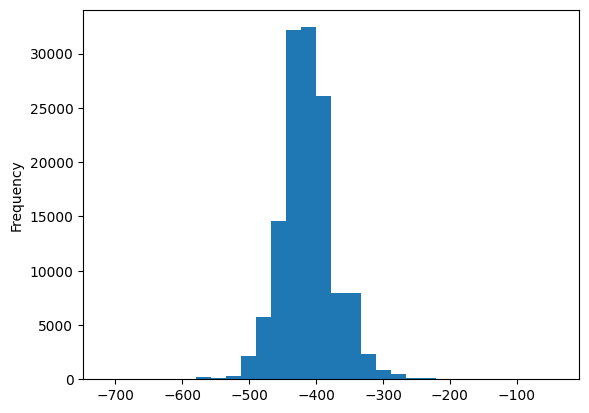

In [249]:
gdb9['u0'].plot.hist(bins=30)

In [72]:
e.shape,x.shape,a.shape

(torch.Size([8, 8, 8]), torch.Size([8, 5]), torch.Size([8, 8, 1]))

In [214]:
__num_nodes=9
__x_features=5
__x_dims=3
__e_features=2
x=torch.randn(__num_nodes,__x_features)
wr=torch.randn(__e_features,__x_features,__x_dims)
e=torch.randn(__num_nodes,__num_nodes,__e_features)
a=(torch.randn(__num_nodes,__num_nodes)>0)

In [202]:
__x=torch.einsum(x, [..., 0, 1], wr, [2, 1, 3], [..., 2, 0, 3])
__y=torch.einsum(e*a, [..., 1, 2, 0], __x, [..., 0,2,3], [1, 3])#.sum(-3)
__y.shape

torch.Size([9, 3])

In [216]:
torch.einsum('abc,ab->abc',e,a)

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 1.0230e+00,  2.4992e+00],
         [-0.0000e+00, -0.0000e+00],
         [-1.3810e+00, -5.6486e-01],
         [ 1.7939e-01,  1.0669e+00],
         [-0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00],
         [-4.3401e-01,  1.2213e+00]],

        [[ 1.2168e+00,  5.2161e-01],
         [ 3.1140e-01,  1.8250e+00],
         [-0.0000e+00,  0.0000e+00],
         [-1.1819e+00,  1.8025e+00],
         [-1.4961e-01,  4.3280e-03],
         [-0.0000e+00, -0.0000e+00],
         [-9.3037e-01,  2.2996e+00],
         [-9.9957e-01, -2.3330e+00],
         [-0.0000e+00, -0.0000e+00]],

        [[-0.0000e+00,  0.0000e+00],
         [-1.5654e+00, -2.7474e-01],
         [ 1.0368e-03, -6.9726e-01],
         [ 4.3336e-01, -1.2369e+00],
         [ 1.3748e+00,  1.0889e+00],
         [-3.8909e-01, -2.4145e-01],
         [ 0.0000e+00, -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00

$O_{kil}=X_{ij}W_{kjl}$

$H_{bd}=E_{abc}O_{acd}$

In [204]:
__t=torch.einsum('bca,bcf,ce,aed->bd',e,a,x,wr)
__t.shape

torch.Size([9, 3])

In [255]:
torch.einsum('bca,bc,ce->bae',e,a,x).shape

torch.Size([9, 2, 5])

In [250]:
__t=torch.einsum('bca,bc,ce,aed->bd',e,a,x,wr)
__t1=(torch.einsum('bca,bc,ce->bae',e,a,x))
__t2=torch.einsum('bae,aed->bd',__t1,wr)
(__t2-__t).sum()

tensor(0.)

In [236]:
__t1.shape,__t2.shape,__t.shape

(torch.Size([9, 2, 5]), torch.Size([9, 3]), torch.Size([9, 3]))

In [211]:
(e*a)-torch.einsum('abc,ab->abc',e,a[...,0])

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
  

In [217]:
__t=torch.einsum('ikl,ik,kn,lnj->ij',e,a,x,wr)
__t.shape

torch.Size([9, 3])

In [218]:
__t

tensor([[ -9.1913, -14.3609,   6.9741],
        [-17.4646,   8.2747,  25.5398],
        [  0.3774,  -1.2827,  -7.9322],
        [ -7.4846,   3.7114,  -1.0713],
        [ 43.9281, -15.0339,  -5.0697],
        [ -2.6267,  -1.7418,  -6.1004],
        [  2.5439,  -1.1132,  -4.7787],
        [  1.8885,  -7.8162,   1.6850],
        [-18.5795,   5.4802,  -1.8069]])

In [ ]:

self.num_relations=len(BONDS)-1
self.in_dim=in_dim
self.out_dim=out_dim
self.do_rate=do_rate
self.wr=nn.Parameter(torch.empty(self.num_relations, in_dim, out_dim))
self.w0=nn.Parameter(torch.empty(in_dim, out_dim))
def forward(self, 
            inputs, 
            use_old=False
           ):
    if use_old:
        raise Exception("use_old is not allowed")
    X,A=inputs
    right_side=X@self.w0

    tmp1 = torch.einsum(X, [..., 0, 1], self.wr, [2, 1, 3], [..., 0, 2, 3]).transpose(-3,-2)
    #we use A[...,1:,:,:] <- the 1: is important because A[...,0,:,:] is the ZERO BOND therefor they shouldn't propagate
    tmp2 = (A[...,1:,:,:]@tmp1)
    cir = (A[...,1:,:,:].sum(-1).unsqueeze(-1))
    #print(cir.shape, tmp2.shape)
    #raise Exception("Bruh")
    # Method 1 (error in back propagation)
    #tmp2_div_cir = torch.where((tmp2 == 0) & (cir == 0), torch.tensor(0.0), tmp2 / cir)
    
    # Method 2 (bad feeling about this, because of epsilon)
    #tmp2_div_cir = tmp2 / (cir+1e-9)
    
    # Method 3
    tmp2_div_cir = tmp2*torch.where(cir==0.0, 0.0, 1/cir)
    
    
    left_side = tmp2_div_cir.sum(-3)
    h = left_side+right_side
    if self.activation_function is not None:
        h =self.activation_function(h)
    h=nn.functional.dropout(h,p=self.do_rate)
    return h,A



$$
\mathbf{m}_{ij}^{(k)} = \text{MESSAGE}(\mathbf{h}_i^{(k-1)}, \mathbf{h}_j^{(k-1)}, \mathbf{e}_{ij})
$$

$$
\mathbf{h}_i^{(k)} = \text{UPDATE}(\mathbf{h}_i^{(k-1)}, \text{PROPAGATE}( \mathbf{m}_{ij}^{(k)} | j \in \mathcal{N}(i)))
$$


# Ways of incorporating edge features

## Addition

$$
\mathbf{h}_i^{(k)} = \text{MLP}^{(k)}\left(\left(1 + \epsilon^{(k)}\right) \mathbf{h}_i^{(k-1)} + \sum_{j \in \mathcal{N}(i)} \mathbf{h}_j^{(k-1)}\right)
$$

## Ours

$$
E \cdot A X W
$$

where the node-wise formulation is:

$$
h_i^{t+1}
$$

# Graph Isomorphism Network (GIN)

$$
\mathbf{h}_i^{(k)} = \text{MLP}^{(k)}\left(\left(1 + \epsilon^{(k)}\right) \mathbf{h}_i^{(k-1)} + \sum_{j \in \mathcal{N}(i)} \mathbf{h}_j^{(k-1)}\right)
$$


# Graph Convolutional Network (GCN)

$$
\mathbf{h}_i^{(k)} = \sigma\left(\sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{\hat{d}_i \hat{d}_j}} \mathbf{W}^{(k)} \mathbf{h}_j^{(k-1)} \right)
$$

Where $(\hat{d}_i)$ and $(\hat{d}_j)$ are the degrees of nodes $(i)$ and $(j)$, including self-loops. $(\sigma)$ is an activation function.

# Relational Graph Convolutional Network (R-GCN)

$$
\mathbf{h}_i^{(k)} = \sigma\left(\sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}r(i)} \frac{1}{c_{i,r}} \mathbf{W}_r^{(k)} \mathbf{h}_j^{(k-1)}\right)
$$

Designed for multi-relational graphs, using different weights $( \mathbf{W}_r )$ for each edge type $( r )$.

# GCN

$$
X=\hat{A}X.L.\sigma
$$

# GIN

$$
h_i := \{h_i\} || \mathcal{N}(h_i) . {\textstyle \sum} .  ( L . \sigma ) *
$$

$$
\mathbf{X}:=\mathbf{\hat{A}}\mathbf{X}.(L.\sigma)*
$$

# 3 layer MLP

$$
X .  ( L . \sigma ) *
$$

A Multi-Layer Perceptron (MLP) can indeed be viewed as a composition of functions. A typical MLP with three layers can be expressed as a composition of functions representing each layer. Here’s how you can write it:

Given:

Input vector: $\mathbf{x}$
Weight matrices: $\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3$
Bias vectors: $\mathbf{b}_1, \mathbf{b}_2, \mathbf{b}_3$
Activation functions: $\sigma_1, \sigma_2, \sigma_3$
The MLP can be represented as:

$$
f(\mathbf{x}) = (f_3 \circ f_2 \circ f_1)(\mathbf{x})
$$

Where:

$f_1(\mathbf{x}) = \sigma_1(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$

$f_2(\mathbf{z}) = \sigma_2(\mathbf{W}_2 \mathbf{z} + \mathbf{b}_2)$

$f_3(\mathbf{z}) = \sigma_3(\mathbf{W}_3 \mathbf{z} + \mathbf{b}_3)$

In this formulation, each $f_i$ represents the function of a single layer, including the affine transformation (weight multiplication and bias addition) followed by an activation function. The composition $f = f_3 \circ f_2 \circ f_1$ denotes applying these transformations sequentially to compute the output from the input $\mathbf{x}$.









In [6]:
d=parse_mol_dict(parse_sdf_file("molparser/example.mol",n=2)[0])

In [8]:
densifier=ToDense()